In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import kapre
import keras
import os
import soundfile as sf
import time
import progressbar
import gc
import h5py

Using TensorFlow backend.


In [2]:
# CONVOLUTIONAL NETWORK

In [3]:
# Define a model whose first layer is a mel-spectrogram (from Kapre)
from keras.models import Sequential
from keras import layers
from kapre.time_frequency import Melspectrogram
from kapre.utils import Normalization2D
from kapre.augmentation import AdditiveNoise

In [4]:
# Code inspired by https://github.com/keunwoochoi/kapre
input_shape = (1, 88200)
sr = 44100

model = Sequential()
# A mel-spectrogram layer
model.add(Melspectrogram(n_dft=512, n_hop=256, input_shape=input_shape,
                         padding='same', sr=sr, n_mels=64,
                         fmin=0.0, fmax=sr/2, power_melgram=1.0,
                         return_decibel_melgram=False, trainable_fb=False,
                         trainable_kernel=False,
                         name='trainable_stft'))
# Add some white noise
model.add(AdditiveNoise(power=0.2))
# Normalise it per-frequency
model.add(Normalization2D(str_axis='batch')) # or 'channel', 'time', 'batch', 'data_sample'
# Add convolution layers
model.add(layers.Conv2D(16, (3, 3), activation = 'relu'))
model.add(layers.Conv2D(16, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((3,3)))
model.add(layers.Dropout(rate=0.1))

model.add(layers.Conv2D(32, (3, 3), activation = 'relu'))
model.add(layers.Conv2D(32, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((3,3)))
model.add(layers.Dropout(rate=0.1))

model.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((3,3)))
model.add(layers.Dropout(rate=0.1))

model.add(layers.Flatten())
model.add(layers.Dense(5, activation='softmax'))

In [5]:
# Load the training and validation data from hdf5
training = h5py.File('/data/musicnet/hdf5/train_data.hdf5', 'r')
validation = h5py.File('/data/musicnet/hdf5/val_data.hdf5', 'r')

list(training.keys())
training_data = training['data']
training_targets = training['targets']

list(validation.keys())
validation_data = validation['data']
validation_targets = validation['targets']

In [6]:
# Compile model
from keras import optimizers
model.compile(optimizer = 'adam',
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])

In [7]:
file_path="/home/ubuntu/code/trained_model/music/music-weights-improvement-{epoch:02d}-{val_loss:.4f}-{val_acc:.2f}.hdf5"
tensorboard_path = "/home/ubuntu/code/tensorboard/"

callbacks_list = [
        keras.callbacks.EarlyStopping(monitor='acc', patience=2,),
        keras.callbacks.ModelCheckpoint(filepath=file_path, monitor='val_loss', save_best_only=True,),
        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=8,),
        keras.callbacks.TensorBoard(log_dir=tensorboard_path, batch_size=32,)]

history = model.fit(training_data, 
                    training_targets,
                    epochs = 40,
                    batch_size = 100,
                    callbacks=callbacks_list,
                    validation_data=(validation_data, validation_targets),
                    shuffle=False)

Train on 39472 samples, validate on 8089 samples
Epoch 1/40
39472/39472 [==============================] - 90s 2ms/step - loss: 1.2596 - acc: 0.5734 - val_loss: 1.1630 - val_acc: 0.6268
Epoch 2/40
39472/39472 [==============================] - 86s 2ms/step - loss: 1.1689 - acc: 0.5937 - val_loss: 1.0805 - val_acc: 0.6102
Epoch 3/40
39472/39472 [==============================] - 86s 2ms/step - loss: 1.0832 - acc: 0.6119 - val_loss: 1.0363 - val_acc: 0.6168
Epoch 4/40
39472/39472 [==============================] - 86s 2ms/step - loss: 1.0339 - acc: 0.6240 - val_loss: 0.9788 - val_acc: 0.6281
Epoch 5/40
39472/39472 [==============================] - 86s 2ms/step - loss: 0.9938 - acc: 0.6355 - val_loss: 0.9315 - val_acc: 0.6411
Epoch 6/40
39472/39472 [==============================] - 86s 2ms/step - loss: 0.9606 - acc: 0.6454 - val_loss: 0.9015 - val_acc: 0.6546
Epoch 7/40
39472/39472 [==============================] - 86s 2ms/step - loss: 0.9339 - acc: 0.6522 - val_loss: 0.8932 - val_acc:

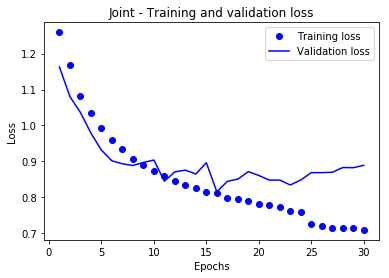

In [8]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Total Loss
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Joint - Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

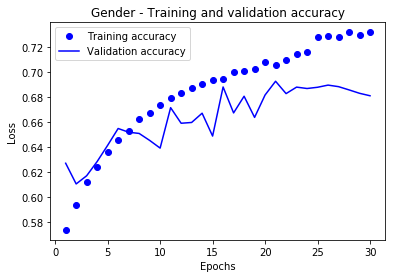

In [9]:
acc = history.history['acc']
val_acc = history.history['val_acc']
epochs = range(1, len(loss) + 1)
plt.subplots(1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Gender - Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [10]:
# Do test predictions and compare performance with baseline
test = h5py.File('/data/musicnet/hdf5/test_data.hdf5', 'r')

list(test.keys())
test_data = test['data']
test_targets = test['targets']

In [11]:
training_targets.shape

(39472, 5)

In [12]:
test_predictions = model.predict(test_data)

In [13]:
test_predicted_labels = np.argmax(test_predictions, axis=1)
test_target_labels = np.argmax(test_targets, axis=1)

In [14]:
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
print('Accuracy ', accuracy_score(test_target_labels, test_predicted_labels))
print(classification_report(test_target_labels, test_predicted_labels))

Accuracy  0.6434733257661748
             precision    recall  f1-score   support

          0       0.63      0.80      0.70       905
          1       0.67      0.83      0.75      4889
          2       0.50      0.33      0.40       810
          3       0.61      0.23      0.33       835
          4       0.53      0.31      0.39      1371

avg / total       0.63      0.64      0.61      8810



In [15]:
# Compare with baseline classifier (in this case we pick the most popular class)
most_popular = np.argmax(np.bincount(test_target_labels))

In [16]:
baseline_prediction = np.repeat(most_popular, test_target_labels.shape[0])

In [17]:
print('Accuracy ', accuracy_score(test_target_labels, baseline_prediction))
print(classification_report(test_target_labels, baseline_prediction))

Accuracy  0.5549375709421113
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       905
          1       0.55      1.00      0.71      4889
          2       0.00      0.00      0.00       810
          3       0.00      0.00      0.00       835
          4       0.00      0.00      0.00      1371

avg / total       0.31      0.55      0.40      8810



/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [20]:
# Compare with baseline classifier (predicting randomly based on popularity of each class)
unique, counts = np.unique(test_target_labels, return_counts=True)
props = counts / sum(counts)
random_predictions = np.random.choice(5, test_target_labels.shape[0], props.any())

In [21]:
print('Accuracy ', accuracy_score(test_target_labels, random_predictions))
print(classification_report(test_target_labels, random_predictions))

Accuracy  0.2
             precision    recall  f1-score   support

          0       0.11      0.21      0.14       905
          1       0.56      0.20      0.30      4889
          2       0.09      0.21      0.13       810
          3       0.10      0.20      0.13       835
          4       0.14      0.18      0.16      1371

avg / total       0.36      0.20      0.23      8810

